In [15]:
!git clone https://www.modelscope.cn/datasets/Kpillow/SceneVTG-Erase.git

fatal: destination path 'SceneVTG-Erase' already exists and is not an empty directory.


In [16]:
import datasets
import pandas as pd
ds=datasets.load_from_disk('dataset')
ds

Dataset({
    features: ['id', 'length', 'group', 'format', 'canvas_width', 'canvas_height', 'category', 'title', 'suitability', 'keywords', 'industries', 'preview', 'type', 'left', 'top', 'width', 'height', 'angle', 'opacity', 'color', 'image', 'text', 'font', 'font_size', 'font_bold', 'font_italic', 'text_line', 'text_color', 'text_align', 'capitalize', 'line_height', 'letter_spacing', 'cluster_index'],
    num_rows: 50
})

In [17]:
pip uninstall -y cr-renderer

Found existing installation: cr-renderer 0.1.0
Uninstalling cr-renderer-0.1.0:
  Successfully uninstalled cr-renderer-0.1.0
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install "C:\Users\pulki\Downloads\temp_fold\cr-renderer"

Processing c:\users\pulki\downloads\temp_fold\cr-renderer
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for cr-renderer: filename=cr_renderer-0.1.0-py3-none-any.whl size=17382 sha256=5d82ab8ec553b96ad5b94f8c2536d14bfe6ab9d07ed599078f864ec4a4cfc70d
  Stored in directory: c:\users\pulki\appdata\local\pip\cache\wheels\c5\03\08\6ffff98cd9d5b898d81a08adf9554fd990cdfafb61f1b054d8
Successfully built cr-renderer
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
import datasets
import huggingface_hub
from cr_renderer import CrelloV5Renderer
fonts_path = huggingface_hub.hf_hub_download(
    repo_id="cyberagent/crello",
    filename="resources/fonts.pickle",
    repo_type="dataset",
    revision="5.0.0",
)
renderer = CrelloV5Renderer(ds.features, fonts_path)

In [57]:
import random
import json

def mirror_distortion(text):
    
    with open("mirror_distortion.json", "r", encoding="utf-8") as f:
        mirror_data = json.load(f)
        
    number=random.randint(0,len(text)//2)
    random_index=random.sample(range(len(text)),k=number)
    text_copy=list(text)
    
    for idx in random_index:
        working_char=text[idx]
        mirror_type=['HORIZONTAL_MIRROR_MULTI','VERTICAL_MIRROR_MULTI','ROTATION_180_MULTI']

        attempt=0
        while(attempt<10):
            selected_type=random.choice(mirror_type)
            if(working_char not in mirror_data[selected_type]):
                attempt+=1
                continue

            replacement=random.choice(mirror_data[selected_type][working_char])
            print("Replacing ",working_char," with ",replacement)
            text_copy[idx]=replacement
            attempt+=1
            break

    text_copy=''.join(text_copy)
    return text_copy




def char_level_repetition_distortion(text: str, max_repeats: int = 2):

    num_positions = random.randint(1, min(4, len(text)))  # up to 4 random spots
    random_indices = random.sample(range(len(text)), k=num_positions)

    distorted = ""
    for i, ch in enumerate(text):
        distorted += ch
        if i in random_indices:
            repeat_count = random.randint(1, max_repeats)
            distorted += ch * repeat_count

    return distorted

def char_level_drop_distortion(text: str, max_drops: int = 3):
    
    num_drops = random.randint(1, min(max_drops, len(text) // 2))
    drop_indices = set(random.sample(range(len(text)), k=num_drops))

    distorted = "".join(ch for i, ch in enumerate(text) if i not in drop_indices)
    return distorted

def adjacent_char_swap_distortion(text: str, max_swaps: int = 2):
    """Swaps two adjacent alphanumeric characters at random positions."""
    text_list = list(text)
    if len(text_list) < 2:
        return text

    # Find valid indices to swap (don't want to swap a letter with a space or punctuation)
    valid_indices = [
        i for i in range(len(text_list) - 1)
        if text_list[i].isalnum() and text_list[i+1].isalnum()
    ]
    
    if not valid_indices:
        return text

    num_swaps = random.randint(1, min(max_swaps, len(valid_indices)))
    swap_indices = random.sample(valid_indices, k=num_swaps)
    
    for idx in swap_indices:
        # Check again in case a previous swap invalidated this one (unlikely but safe)
        if text_list[idx].isalnum() and text_list[idx+1].isalnum():
            text_list[idx], text_list[idx+1] = text_list[idx+1], text_list[idx]
            
    return "".join(text_list)

def same_char_distortion(text):
    # print("Input: ",text)
    with open("same_char.json", "r", encoding="utf-8") as f:
        same_char_data = json.load(f)
    
    number=random.randint(0,len(text)//2)
    random_index=random.sample(range(len(text)),k=number)
    
    text_copy=list(text)                            
    for idx in random_index:
    
        working_char=text[idx]
        
        if(working_char in same_char_data):
            replacement=random.choice(same_char_data[working_char])
            print("Replacing ",working_char," with ",replacement)
            text_copy[idx]=replacement
            break
    
    text_copy=''.join(text_copy)
    # print("Output: ",text_copy)
    return text_copy

def case_shuffle_distortion(text):
    """Randomly shuffles case of all characters"""
    distorted = ""
    for ch in text:
        if ch.isalpha():
            distorted += ch.upper() if random.random() < 0.5 else ch.lower()
        else:
            distorted += ch
    return distorted

def noise_injection_distortion(text, max_noise: int = 5):
    """Injects random noise characters at random positions"""
    noise_chars = ['·', '˙', '`', '´', '¨', '˚', '°']
    
    text_list = list(text)
    num_noise = random.randint(1, min(max_noise, len(text)))
    
    for _ in range(num_noise):
        idx = random.randint(0, len(text_list))
        text_list.insert(idx, random.choice(noise_chars))
    
    return ''.join(text_list)

def ocr_confusion_distortion(text: str, max_confusions: int = 2):
    ocr_pairs = {
        # Multi-character to single character confusions
        'rn': 'm', 'nn': 'u', 'vv': 'w', 'uu': 'w', 'ii': 'u',
        'cl': 'd', 'li': 'h', 'Il': 'H', 'ln': 'h', 'rr': 'n',
        'iii': 'm', 'ri': 'n', 'RN': 'M', 'VV': 'W', 'UU': 'W',
        'tt': 'H', 'IVI': 'M', 'AI': 'N', 'NN': 'M', 'AA': 'M',
        
        # Single character to multi-character confusions
        'm': 'rn', 'w': 'vv', 'u': 'ii', 'n': 'ri', 'h': 'li',
        'M': 'RN', 'W': 'VV', 'H': 'tt', 'N': 'AI',
        
        # Number/letter confusions (multi-char patterns)
        '0O': 'OO', 'O0': '00', 'l1': '11', '1l': 'll', 
        'I1': '11', '1I': 'II', 'S5': '55', '5S': 'SS',
        'B8': '88', '8B': 'BB', 'G6': '66', '6G': 'GG',
        
        # Common word-specific OCR errors
        'tlie': 'the', 'tbe': 'the', 'tiie': 'the', 'thc': 'the',
        'aud': 'and', 'arid': 'and', 'aiid': 'and', 'ancl': 'and',
        'of': 'ol', 'ot': 'of', 'ol': 'of', 'for': 'lor', 'tor': 'for',
        'Mr': 'Nfr', 'Mrs': 'Nfrs', 'Mr.': 'Mr,', 'Mrs.': 'Mrs,',
        'was': 'vvas', 'will': 'vvill', 'with': 'witli', 'from': 'frorn',
        'that': 'tliat', 'this': 'tliis', 'which': 'wliich', 'when': 'wlien',
        'been': 'beeu', 'have': 'liave', 'said': 'sald', 'upon': 'upou',
        
        # Long s (historical OCR)
        'fs': 'ss', 'fl': 'fi', 'fi': 'fl', 'fh': 'sh', 'ft': 'st',
        
        # Punctuation and special character confusions
        ').': ')', '.)': '.)', ',)': ').', ',.': ',', '.,': '.,',
        ';"': ';', '":': ':', "';": "'", ".'": ".'",
        
        # Common prefix/suffix errors
        'tlie': 'the', 'witli': 'with', 'wliich': 'which', 'tliey': 'they',
        'tliis': 'this', 'liere': 'here', 'wlien': 'when', 'wliat': 'what',
        'tbing': 'thing', 'tbat': 'that', 'tion': 'lion', 'sion': 'siou',
        
        # Double letter confusions
        'ff': 'fi', 'fi': 'ff', 'tt': 'H', 'il': 'II', 'oo': 'œ',
        
        # Capitalization OCR errors
        'Tlie': 'The', 'Tbe': 'The', 'Wlien': 'When', 'Witli': 'With',
        'Wliich': 'Which', 'Frorn': 'From', 'Tliis': 'This', 'Tliat': 'That'
    }
    
    # Attempt replacements
    for _ in range(max_confusions):
        for pattern, replacement in ocr_pairs.items():
            if pattern in text and random.random() < 0.3:
                positions = [i for i in range(len(text) - len(pattern) + 1) 
                           if text[i:i+len(pattern)] == pattern]
                if positions:
                    idx = random.choice(positions)
                    text = text[:idx] + replacement + text[idx+len(pattern):]
                    break
    
    return text


def subscript_superscript_distortion(text: str, max_conversions: int = 2):
    superscripts = {'0': '⁰', '1': '¹', '2': '²', '3': '³', '4': '⁴',
                   '5': '⁵', '6': '⁶', '7': '⁷', '8': '⁸', '9': '⁹',
                   'a': 'ᵃ', 'b': 'ᵇ', 'c': 'ᶜ', 'd': 'ᵈ', 'e': 'ᵉ'}
    
    subscripts = {'0': '₀', '1': '₁', '2': '₂', '3': '₃', '4': '₄',
                 '5': '₅', '6': '₆', '7': '₇', '8': '₈', '9': '₉'}
    
    conversion_map = {**superscripts, **subscripts}
    
    text_list = list(text)
    valid_indices = [i for i, ch in enumerate(text) if ch in conversion_map]
    
    if not valid_indices:
        return text
    
    num_conversions = random.randint(1, min(max_conversions, len(valid_indices)))
    conversion_indices = random.sample(valid_indices, k=num_conversions)
    
    for idx in conversion_indices:
        text_list[idx] = conversion_map[text[idx]]
    
    return ''.join(text_list)


def zalgo_distortion(text: str, max_intensity: int = 3, max_chars: int = 5):
    
    if(len(text)<=8):
        return text
    """Adds stacking 'combining' diacritic marks to random characters."""
    # A selection of combining marks
    DIACRITICS = [
        # Above
        '\u0300', '\u0301', '\u0302', '\u0303', '\u0304', '\u0305', '\u0306', '\u0307', 
        '\u0308', '\u030A', '\u030B', '\u030C', '\u030D', '\u030E', '\u030F', '\u0310', 
        '\u0311',
        # Middle (includes your strikethrough)
        '\u0334', '\u0335', '\u0336', '\u0337', '\u0338',
        # Below
        '\u0316', '\u0317', '\u0318', '\u0319', '\u031A', '\u031B', '\u031C', '\u031D',
        '\u031E', '\u031F', '\u0320', '\u0321', '\u0322', '\u0323', '\u0324', '\u0325',
        '\u0326', '\u0327', '\u0328', '\u0329', '\u032A'
    ]
    
    text_list = list(text)
    
    # Find non-space characters to distort
    valid_indices = [i for i, char in enumerate(text) if not char.isspace()]
    if not valid_indices:
        return text

    num_chars_to_distort = random.randint(1, min(max_chars, len(valid_indices)))
    distort_indices = random.sample(valid_indices, k=num_chars_to_distort)
    
    for idx in sorted(distort_indices, reverse=True):
        num_diacritics = random.randint(1, max_intensity)
        for _ in range(num_diacritics):
            text_list.insert(idx + 1, random.choice(DIACRITICS))
    
    return "".join(text_list)

def distort(example,distortion_list):
    text=example['text']
    
    
    
    for ind in range(len(text)):
        working_text=text[ind]
        if(working_text==''):
            continue
        else:
            for distortion in distortion_list:
                if(distortion=='repetition'):
                    working_text=char_level_repetition_distortion(working_text)
                elif(distortion=='drop'):
                    working_text=char_level_drop_distortion(working_text)
                elif(distortion=='mirror'):
                    working_text=mirror_distortion(working_text)
                elif(distortion=='same_char'):
                    working_text=same_char_distortion(working_text)
                elif(distortion=='case_shuffle'):
                    working_text=case_shuffle_distortion(working_text)
                elif(distortion=='noise_injection'):
                    working_text=noise_injection_distortion(working_text)
                elif(distortion=='adjacent_char_swap'):
                    working_text=adjacent_char_swap_distortion(working_text)
                elif(distortion=='zalgo'):
                    working_text=zalgo_distortion(working_text)
                elif(distortion=='ocr_confusion'):
                    working_text=ocr_confusion_distortion(working_text)
                elif(distortion=='subscript_superscript'):
                    working_text=subscript_superscript_distortion(working_text)
                    
        
        text[ind]=working_text
    example['text']=text
    return example
    
def selecting_working_text(example):
    font_sizes = example['font_size']
    unique_sizes = sorted(set(font_sizes), reverse=True)
    val = unique_sizes[:2]
    
    # selection of biggest two font sizes
    for ind in range(len(font_sizes)):
    
        if(example['font_size'][ind]==0):
            continue

        if(example['font_size'][ind]!=val[0] and example['font_size'][ind]!=val[1]):
            example['text'][ind]=""  
    return example     

['', '', '', '', '', 'is confidence applied directly to your face', 'Beauty', '']
[0, 0, 0, 6, 6, 6, 6, 0]


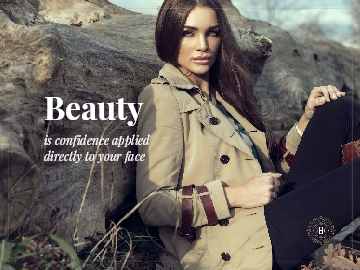

In [67]:
from PIL import Image
from io import BytesIO
example=ds[1]
example=selecting_working_text(example)
example=distort(example,distortion_list=[
                                        # 'mirror',
                                        # 'repetition',
                                        #  'drop',
                                        #  'same_char',
                                        # 'case_shuffle',
                                        # 'noise_injection',
                                        # 'adjacent_char_swap',
                                        # 'zalgo',
                                        'ocr_confusion',
                                        # 'subscript_superscript'
                                         ])
print(example['text'])
print(example['font'])
# for i in example['font']:
#     if example['font']!=0:
#         example['font']=2
rendered_image = renderer.render(example)
Image.open(BytesIO(rendered_image))

['', 'Back to school', "It's a new beginning"]
[49.0, 21.0]
[0.0, 49.0, 21.0]


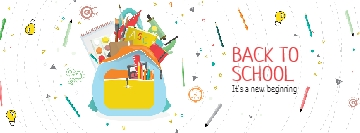

In [22]:
temp=ds[5]
print(temp['text'])

font_sizes = temp['font_size']
unique_sizes = sorted(set(font_sizes), reverse=True)
val = unique_sizes[:2]
print(val)

for ind in range(len(temp['font_size'])):
    
    if(temp['font_size'][ind]==0):
        continue

    if(temp['font_size'][ind]!=val[0] and temp['font_size'][ind]!=val[1]):
        temp['text'][ind]=""
        
print(temp['font_size'])
    
# temp['text'][7]='Hosted Hosted by by Boyd House & Juno Foundation\n3112 Riverview Rd'

image_bytes = renderer.render(temp)
from PIL import Image
from io import BytesIO

Image.open(BytesIO(image_bytes))

In [23]:
temp['text']

['', 'Back to school', "It's a new beginning"]

In [24]:
temp['type']

[2, 1, 1]

In [25]:
temp

{'id': '5b6c54c41cc8aa542927ade7',
 'length': 3,
 'group': 1,
 'format': 3,
 'canvas_width': 851,
 'canvas_height': 315,
 'category': 9,
 'title': 'Back to School with Stationary in backpack',
 'suitability': [0],
 'keywords': ['back to school',
  'education',
  'geometry',
  'knowledge',
  'learning',
  'math',
  'mathematics',
  'measuring',
  'notebook',
  'pencils',
  'rubber',
  'schedule',
  'school',
  'stationery',
  'studying',
  'tools',
  'backpack',
  'facebook',
  'cover',
  'fb',
  'backtoschool'],
 'industries': [5, 0, 3],
 'preview': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x190>,
 'type': [2, 1, 1],
 'left': [-1.399999976158142, 548.515625, 549.0],
 'top': [-0.800000011920929, 106.11231994628906, 201.0],
 'width': [853.0999755859375, 190.0, 190.0],
 'height': [315.79998779296875, 90.0, 21.0],
 'angle': [0.0, 0.0, 0.0],
 'opacity': [1.0, 1.0, 1.0],
 'color': [[], [], []],
 'image': [<PIL.PngImagePlugin.PngImageFile image mode=RGBA size=512x190>,
  <PIL.

In [26]:
img

NameError: name 'img' is not defined

In [ ]:
import ast

In [ ]:
import ast

# Your input string
string_representation = "{'bytes': '\\\\x'}"

# Safely evaluate the string to create a dictionary
actual_dict = ast.literal_eval(string_representation)

# Print the result and its type to confirm
print(actual_dict)
print(type(actual_dict))

{'bytes': '\\x'}
<class 'dict'>
